In [1]:
import numpy as np
import cv2
from skimage.segmentation import slic
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import scipy.spatial.distance

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
class Features:
    def __init__(self, query_keys, query_des, train_keys, train_des):
        self.query_keys = query_keys
        self.query_des = query_des
        self.train_keys = train_keys
        self.train_des = train_des

In [3]:
def imageResize(image):
    resize_image = cv2.resize(src=image, dsize=(512, 512))
    return image

In [4]:
def getKeysAndDescriptorsDict(segments, image):
    sift = cv2.SIFT_create()
    key_disc_dict = {}
    unique_segments = np.unique(segments)
    for segmentValue in unique_segments:
        rows, cols = np.where(segments == segmentValue)
        region_of_interest = image[min(rows):max(rows), min(cols):max(cols)]
        image_without_roi = image.copy()
        image_without_roi[min(rows):max(rows), min(cols):max(cols)] = 0
        query_keys, query_des = sift.detectAndCompute(cv2.cvtColor(region_of_interest,cv2.COLOR_BGR2GRAY), None)
        train_keys, train_des = sift.detectAndCompute(cv2.cvtColor(image_without_roi,cv2.COLOR_BGR2GRAY), None)
        if query_des is not None:  #adding only if at least one key point is found
            key_disc_dict[segmentValue] = Features(query_keys=query_keys, query_des=query_des, train_keys=train_keys,
                                                train_des=train_des)
    return key_disc_dict

In [5]:
def getMatchedRegions(key_disc_dict, segments, key_matches_per_cluster=5, cluster_matches_per_cluster=2):
    bf = cv2.BFMatcher()  # Brute Force Matcher
    matched_segments = {}  # the dictionary to hold the matched segments
    for segmentValue in key_disc_dict:
        dic_value = key_disc_dict[segmentValue]
        # To not repeat any checking between two clusters which are already done
        condition = dic_value.query_des is not None
        if condition:
            total_matches = bf.knnMatch(queryDescriptors=dic_value.query_des, trainDescriptors=dic_value.train_des, k=2)
            count = 0  # to keep the count of the number of matches under the threshold
            matching_segments = set()
            # filter out those under the threshold
            for i, m in enumerate(total_matches):
                if len(m) > 1:
                    if m[0].distance < 0.6 * m[1].distance: # condition for a good match
                    	count += 1
                    	col, row = dic_value.train_keys[m[0].trainIdx].pt  # key.pt -> (x,y)|(col,row)|(width,height)
                    	matching_segments.add(segments[int(round(row)), int(round(col))])
            if (count >= key_matches_per_cluster) & (len(matching_segments) >= cluster_matches_per_cluster): #required number condition check.
                print('matching...', segmentValue, ',', matching_segments)
                if segmentValue in matched_segments:
                	# the list of all the matching clusters for a particular cluster will be assigned as value for that particular cluster.
                	# this is to avoid repeated values in the set.
                    matched_segments[segmentValue].extend(
                        x for x in matching_segments if x not in matched_segments[segmentValue]) 
                else:
                    matched_segments[segmentValue] = matching_segments # if there is no previous occurance.
    print(matched_segments, "matched_segments")
    return matched_segments

In [6]:
def drawClonedRegions(image, matchedClusters, segments):
    for matchedClusterNumber in matchedClusters:
        print('matched parent cluster:', matchedClusterNumber, ' |children :', end='', flush=True)

 

        rows1, cols1 = np.where(segments == matchedClusterNumber) #select rows and columns of matched cluster.
        for row1, col1 in zip(rows1, cols1):
            image[row1, col1, 1] = 0  # making the green channel zero.
        if len(matchedClusters[matchedClusterNumber]) >= 1:
            for similarClusterNumber in matchedClusters[matchedClusterNumber]:
                rows2, cols2 = np.where(segments == similarClusterNumber)
                print(similarClusterNumber, ',', end='')
                # Draw lines from starting point of one matched cluster to starting point if another matched cluster
                cv2.line(img=image, pt1=(cols1[0], rows1[0]), pt2=(cols2[0], rows2[0]), color=(255, 0, 0), thickness=3)
                for row2, col2 in zip(rows2, cols2):
                    image[row2, col2, 2] = 0 #Making Blue Channel 0 so as to see the color difference
        print('\n')
    cv2.imshow('Cloning Detection Result', (image))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [35]:
#Main
img = imageResize(cv2.imread(r"C:\Users\HP\Desktop\python\MICC-F220\DSC_1568tamp27.jpg"))

In [36]:
bgrImage = img[:, :, ::-1]  # convert to bgr
segmentedData = slic(image=bgrImage, n_segments=100, sigma=5)

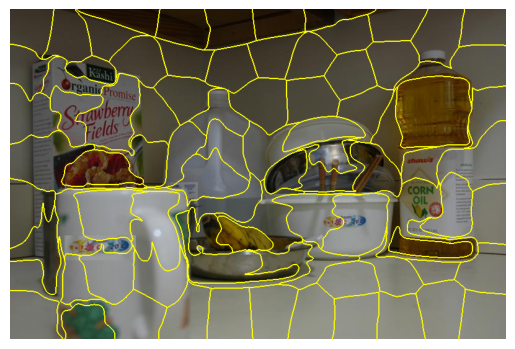

In [37]:
#plotting
figure = plt.figure("SLIC Components")
axis = figure.add_subplot(1, 1, 1)
axis.imshow(mark_boundaries(bgrImage, segmentedData))
plt.axis("off")
plt.show()

In [38]:
print('Number of unique segments :', len(np.unique(segmentedData)))
key_disc_dict = getKeysAndDescriptorsDict(segments=segmentedData, image=img)
print('Dictionary of Segments', len(key_disc_dict))
matchedPatches = getMatchedRegions(key_disc_dict=key_disc_dict, segments=segmentedData, key_matches_per_cluster=2,
									cluster_matches_per_cluster=2)
print('matched patches:', len(matchedPatches))
drawClonedRegions(image=img, matchedClusters=matchedPatches, segments=segmentedData)

Number of unique segments : 85
Dictionary of Segments 48
matching... 55 , {58, 59}
matching... 59 , {23, 55}
{55: {58, 59}, 59: {23, 55}} matched_segments
matched patches: 2
matched parent cluster: 55  |children :58 ,59 ,

matched parent cluster: 59  |children :23 ,55 ,

